# MY MODEL (P11018)

## 1. Find homologs with HMM:

```psiblast -query P11018.fa -db /mnt/NFS_UPF/soft/databases/blastdat/pdb_seq -num_iterations 5 -out P11018_pdb.out```

And will obtain this:

````
Query= P11018

Length=319
                                                                      Score     E
Sequences producing significant alignments:                          (Bits)  Value

1mee_A mol:protein length:275 MESENTERICOPEPTIDASE                    226     2e-72
1scj_A mol:protein length:275 SUBTILISIN E                            223     3e-71
1yjc_A mol:protein length:275 SUBTILISIN 8397+1                       218     2e-69
1yjb_A mol:protein length:275 SUBTILISIN 8397+1                       218     2e-69
1yja_A mol:protein length:275 SUBTILISIN 8397+1                       218     2e-69
1sbh_A mol:protein length:275 SUBTILISIN 8397+1                       218    
````

With this I know that 1meeA, 1scjA and 1yjc are the ones I will be using

### 1.1. Download the fam profile with PFAMa db

Busquem l'HMM de la família utilitzant la base de dades de PFAMa. 

````
hmmpfam2 /mnt/NFS_UPF/soft/databases/pfam-2/Pfam_ls P11018.fa > P11018_pfam.out
````

Obtinc:

````
Scores for sequence family classification (score includes all domains):
Model           Description                             Score    E-value  N 
--------        -----------                             -----    ------- ---
Peptidase_S8    Subtilase family                        411.9   1.1e-120   1
LacAB_rpiB      Ribose/Galactose Isomerase              -96.7          1   1
ETF             Electron transfer flavoprotein domain   -56.0          7   1
ABC_sub_bind    ABC transporter substrate binding pro  -158.2        9.2   1
````

Ara sabem que pertanyen a la família de la Peptidase_S8! Ens servirà per extreure el seu HMM:


```
jackhmmer --chkhmm P11018_profile P11018.fa /mnt/NFS_UPF/soft/databases/blastdat/uniprot_sprot.fasta
```

```--chkhm``` és perquè obtingui com a resultat 5 (per defecte) fitxers amb el nom ```P11018_profile-N.hmm```

### 1.2. Once have a specific HMM model, use ```hmmsearch``` against a sequence db (PDB; Unirpot) to find the homologs

En aquest pas agafaré el perfil 5, ja que com més voltes, millor el valor del e-value i això voldrà dir que és menys probable que hagi passat per atzar. 
        
````
hmmsearch P11018_profile-5.hmm /mnt/NFS_UPF/soft/databases/blastdat/pdb_seq > Peptidase_S8_pdb.out


Query:       P11018-i4  [M=319]
Scores for complete sequences (score includes all domains):
   --- full sequence ---   --- best 1 domain ---    -#dom-
    E-value  score  bias    E-value  score  bias    exp  N  Sequence Description
    ------- ------ -----    ------- ------ -----   ---- --  -------- -----------
    5.4e-96  324.2  18.9      6e-96  324.1  18.9    1.0  1  1sbi_A    mol:protein length:275  SUBTILISIN 8397
      1e-95  323.3  19.0    1.1e-95  323.2  19.0    1.0  1  1s01_A    mol:protein length:275  SUBTILISIN BPN'
    1.2e-95  323.0  18.7    1.4e-95  322.9  18.7    1.0  1  1sbh_A    mol:protein length:275  SUBTILISIN 8397+1
    1.2e-95  323.0  18.7    1.4e-95  322.9  18.7    1.0  1  1yja_A    mol:protein length:275  SUBTILISIN 8397+1
    1.2e-95  323.0  18.7    1.4e-95  322.9  18.7    1.0  1  1yjb_A    mol:protein length:275  SUBTILISIN 8397+1
    1.2e-95  323.0  18.7    1.4e-95  322.9  18.7    1.0  1  1yjc_A    mol:protein length:275  SUBTILISIN 8397+1
````

From this file, I will find the homologous seq. I did it before with psiblast, but the results now are quite different...

So as a templates, I will choose: 1sbi_A, 1s01_A and 1sbh_A.


Un cop triats els templates, buscar-los a la base de dades pdb per obtenir les templates en format __pdb__:

````
cp /mnt/NFS_UPF/soft/databases/pdb/pdb/data/structures/divided/pdb/sb/pdb1sbh.ent.gz .
cp /mnt/NFS_UPF/soft/databases/pdb/pdb/data/structures/divided/pdb/sb/pdb1sbi.ent.gz .
cp /mnt/NFS_UPF/soft/databases/pdb/pdb/data/structures/divided/pdb/s0/pdb1s01.ent.gz .

gunzip *gz

cp pdb1sbh.ent 1sbh.pdb
cp pdb1s01.ent 1s01.pdb
cp pdb1sbi.ent 1sbi.pdb

PDBtoSplitChain.pl -i 1sbh.pdb -o 1sbh
PDBtoSplitChain.pl -i 1s01.pdb -o 1s01
PDBtoSplitChain.pl -i 1sbi.pdb -o 1sbi
````

With the PDBtoSplitChain I have obtained chains A in ```pdb``` and ```.fa``` format.

````
cat P11018.fa > alignment.fa
cat 1sbhA.fa >> alignment.fa
cat 1s01A.fa >> alignment.fa
cat 1sbiA.fa >> alignment.fa
````


## 2. Align the ```jackhmmer``` results (the hmm profile) using ```hmmalign```

Here I want P11018 to align it with other homologs obtained from the ```hmmsearch``` . A diferència d'un aliniament seqüència-seqüència normal (com faria ClustalW), aquí estic utilitzant una "plantilla intel·ligent" (el model HMM de Pfam) per col·locar cada aminoàcid al seu lloc correcte segons l'evolució de la família de les globines. El programa mira el model HMM, que ja sap quines posicions de la globina són hèlixs, quines són girs i on és probable que hi hagi una inserció o una deleció (gaps). Agafa la query P11018 i les templates (1sbhA, 1s01A, 1sbiA) i les projecta sobre el model una per una. Com que totes s'han alineat contra el mateix motlle, el resultat és que estan alineades entre elles de la manera més precisa possible des d'un punt de vista biològic.

````
hmmalign P11018_profile-5.hmm alignment.fa > final_alignment.sto
````

El format ```.sto``` és en format stockholm! Per tant, s'ha de convertir en format clustal

## 3. Convert the sto format into alignment one (clustal)

````
aconvertMod2.pl -in h -out c < final_alignment.sto > final_alignment.clu (també li podríem dir .aln)
````

## 3.1. Output of the alignment in clustal format

````
CLUSTAL W(1.60) multiple sequence alignment

P11018  m-NGEIRLIPYVTNEQIMDVNELPEGIKVIKAPEMWAKGVKGKNIKVAVLDTGCDTSHPD
1sbhA   a-------------------QSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPD
1s01A   a-------------------QSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPD
1sbiA   a-------------------QSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPD

P11018  LKNQIIGGKNFTDDDGGKEDAISDYNGHGTHVAGTIAANDSNGGIAGVAPEASLLIVKVL
1sbhA   LK--VAGGASFVPSE---TNPFQDNNSHGTHVAGTVAALDNSIGVLGVAPSASLYAVKVL
1s01A   LK--VAGGASFVPSE---TNPFQDNNSHGTHVAGTVAALDNSIGVLGVAPSASLYAVKVL
1sbiA   LK--VAGGASFVPSE---TNPFQDNNSHGTHVAGTVAALDNSIGVLGVAPSASLYAVKVL

P11018  GGENGSGQYEWIINGINYAVEQKVDIISMSLGGPSDVPELKEAVKNAVKNGVLVVCAAGN
1sbhA   GA-DGSGQYSWIINGIEWAIANNMDVINMSLGGPSGSAALKAAVDKAVASGVVVVAAAGN
1s01A   GA-DGSGQYSWIINGIEWAIANNMDVINMSLGGPSGSAALKAAVDKAVASGVVVVAAAGN
1sbiA   GA-DGSGQYSWIINGIEWAIANNMDVINMSLGGPSGSAALKAAVDKAVASGVVVVAAAGN

P11018  EGDGDERTEELSYPAAYNEVIAVGSVSVARELSEFSNANKEIDLVAPGENILSTLPNKKY
1sbhA   EGTSG-SSSTVGYPAKYPSVIAVGAVDSSNQRASFSSVGPELDVMAPGVSI-STLPGNKY
1s01A   EGTSG-SSSTVGYPAKYPSVIAVGAVDSSNQRASFSSVGPELDVMAPGVSICSTLPGNKY
1sbiA   EGTSG-SSSTVGYPAKYPSVIAVGAVDSSNQRASFSSVGPELDVMAPGVSI-STLPGNKY

P11018  GKLTGTSMAAPHVSGALALIKSYEEESFQRKLSESEVFAQLIRRTLPLDIAKTLAGNGFL
1sbhA   GAYSGTSMASPHVAGAAALILSKHPN-----WTNTQVRSSLENTTTYLGDS-FYYGKGLI
1s01A   GAKSGTSMASPHVAGAAALILSKHPN-----WTNTQVRSSLENTTTKLGDS-FYYGKGLI
1sbiA   GAYSGTSMASPHVAGAAALILSKHPN-----WTNTQVRSSLENTTTKLGDS-FYYGKGLI

P11018  YLTAPDELAEKAEQSHLLT-l--
1sbhA   NVQA----------------aaq
1s01A   NVQA----------------aaq
1sbiA   NVQA----------------aaq
````

Més endavant s'haurà de modificar els extrems N-t i C-t, ja que allí no hi ha aliniament, i els ```-----```s'hauràn de col·locar al prinicipi i al final de tot i la lletra o letres amb minúscula al cantó de les lletres en majúscula. Les lletres en majúscula representen els aminoàcids que s'han alineat amb les columnes de consens del model HMM. Són les posicions que el perfil considera "importants" o conservades de la família. Les lletres en minúscula (com el l de la teva P11018 o el aaq al final de les altres) representen aminoàcids que no encaixen en el model. Són insercions respecte al consens de la família. Aquestes lletres s'anomenen sovint "aminoàcids no alineats" perquè estan fora del motlle principal del perfil.

L'aliniament és excel·lent en el bloc central. Fixa't en la zona:
```HGTHVAGTIA``` (P11018)
```HGTHVAGTVA``` (Templates)
Aquesta és la zona del lloc actiu (on hi ha l'Histidina catalítica). Que estigui tan ben alineada és un senyal verd per fer modelatge 3D; les estructures es plegaran gairebé igual en el nucli de la proteïna.

- A l'inici: La P11018 té ```m-NGEIRLIPY....``` La m minúscula indica que el model HMM comença a comptar a partir de la N. La teva proteïna té una Metionina inicial que no forma part del "motlle" conservat.

- Al final: Les templates tenen ```aaq```. Això vol dir que les estructures PDB tenen 3 aminoàcids al final que la teva P11018 no té (ella acaba en l).

En quant als gaps:

- Zona inicial: Les templates tenen una delecció enorme ```(a-------------------)```. Això vol dir que la teva P11018 té un bucle extra d'uns 20 aminoàcids al principi.

- Zona central: ```LKNQIIGGKNFT``` vs ```LK--VAGGASFV```. La teva proteïna és més llarga aquí.

Interpretació: Quan facis el model 3D, aquestes zones de la P11018 seran les més difícils de predir perquè no tens plantilla on copiar les coordenades. Seran "loops" que sortiran de l'estructura principal.

## 4. MODELLER

Ara fem servir el programa MODELLER per construir el nostre model. Modeller és una implementació automàtica d'una aproximació de modelatge comparatiu que segueix restriccions espacials. Funciona de tal manera que primer, les estructures 3D de les templates s'alinien amb la target, després s'apliquen les restriccions espacials (distància entre Calpha, cadenes laterals, angles...) que es transfereixen de les templates a la target, finalment, s'obté el model 3D. Aquest complirà al màxim de restriccions possibles. 

Modeller només llegirà l'alineament si aquest està en format pir. El programa ```aconvertMod2``` permet fer aquest canvi de format. L'output és un alineament amb tants blocs com seq i cada bloc té un encapçalament i dos línies amb etqiuetes. Aquestes etiquetes hauràn de ser les mateixes que les que posarem a l'input file. 

````
aconvertMod2.pl -in c -out p < final_alignment.clu > final_alignment.pir
````

### 4.1. Modify ```modeling.py``` file

Aquest file conté els paràmetres que necessita Modeller i les opcions que volem fer servir per a construir el meu model 3D. 

- ```alnfile``` on es posa el nom de l'alinimanet en format pir, a partir del qual es construeix els models. Entre cometes!

- ```knowns``` on es posa el nom dels templates utilitzats. Han de tenir el amteix nom que en l'aliniament pir. Entre cometes i separat entre cometes!

- ```sequence``` nom del target (en aquest cas P11018) que també ha d'apareixer a l'aliniment pir. 

Els pdb han d'estar al mateix directori

- ```a.ending_model = 2``` perquè es vol dos models, tot i que es podria fer tants models com vulgui perquè hi ha més d'una solució per a cada restricció espacial. 

- ```a.make()``` NO ES TOCA! Serveix per fer homology modeling de la manera més simple. 

## 4.2. Run modeling.py

Un cop canviat els paràmetres, correm el file .py:

````
modpy.sh python3 modeling.py
````

Com a resultat, obtindré dos models (PER EXEMPLE):

````
>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
P11018.B99990001.pdb          7236.42578
P11018.B99990002.pdb          7223.64941
````

Per més comoditat, els canviaré el nom:

````
mv P11018.B99990001.pdb model1.pdb
mv P11018.B99990002.pdb model2.pdb
````
## 4.3. Visualization on chimera
Visualització amb chimera!!

````
chimera model1.pdb model2.pdb 1sbhA.pdb 1sbiA.pdb 1s01A.pdb
````

I superimposem. 

## 4.4. Modify alignment to enhance the superimposition

Ara:
POsar els gaps al principi, perque ell veia que començaria l'aliniamet per una a, si ho borro merda!

````
CLUSTAL W(1.60) multiple sequence alignment

P11018  m-NGEIRLIPYVTNEQIMDVNELPEGIKVIKAPEMWAKGVKGKNIKVAVLDTGCDTSHPD
1sbhA   -------------------aQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPD
1s01A   -------------------aQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPD
1sbiA   -------------------aQSVPYGVSQIKAPALHSQGYTGSNVKVAVIDSGIDSSHPD

P11018  LKNQIIGGKNFTDDDGGKEDAISDYNGHGTHVAGTIAANDSNGGIAGVAPEASLLIVKVL
1sbhA   LK--VAGGASFVPSE---TNPFQDNNSHGTHVAGTVAALDNSIGVLGVAPSASLYAVKVL
1s01A   LK--VAGGASFVPSE---TNPFQDNNSHGTHVAGTVAALDNSIGVLGVAPSASLYAVKVL
1sbiA   LK--VAGGASFVPSE---TNPFQDNNSHGTHVAGTVAALDNSIGVLGVAPSASLYAVKVL

P11018  GGENGSGQYEWIINGINYAVEQKVDIISMSLGGPSDVPELKEAVKNAVKNGVLVVCAAGN
1sbhA   GA-DGSGQYSWIINGIEWAIANNMDVINMSLGGPSGSAALKAAVDKAVASGVVVVAAAGN
1s01A   GA-DGSGQYSWIINGIEWAIANNMDVINMSLGGPSGSAALKAAVDKAVASGVVVVAAAGN
1sbiA   GA-DGSGQYSWIINGIEWAIANNMDVINMSLGGPSGSAALKAAVDKAVASGVVVVAAAGN

P11018  EGDGDERTEELSYPAAYNEVIAVGSVSVARELSEFSNANKEIDLVAPGENILSTLPNKKY
1sbhA   EGTSG-SSSTVGYPAKYPSVIAVGAVDSSNQRASFSSVGPELDVMAPGVSI-STLPGNKY
1s01A   EGTSG-SSSTVGYPAKYPSVIAVGAVDSSNQRASFSSVGPELDVMAPGVSICSTLPGNKY
1sbiA   EGTSG-SSSTVGYPAKYPSVIAVGAVDSSNQRASFSSVGPELDVMAPGVSI-STLPGNKY

P11018  GKLTGTSMAAPHVSGALALIKSYEEESFQRKLSESEVFAQLIRRTLPLDIAKTLAGNGFL
1sbhA   GAYSGTSMASPHVAGAAALILSKHPN-----WTNTQVRSSLENTTTYLGDS-FYYGKGLI
1s01A   GAKSGTSMASPHVAGAAALILSKHPN-----WTNTQVRSSLENTTTKLGDS-FYYGKGLI
1sbiA   GAYSGTSMASPHVAGAAALILSKHPN-----WTNTQVRSSLENTTTKLGDS-FYYGKGLI

P11018  YLTAPDELAEKAEQSHLLT-l--
1sbhA   NVQAaaq----------------
1s01A   NVQAaaq----------------
1sbiA   NVQAaaq----------------
````
Ara, tornem a fer:

````
aconvertMod2.pl -in c -out p < final_alignment.clu > final_alignment.pir
modpy.sh python3 modeling.py

mv P11018.B99990001.pdb model1.pdb
mv P11018.B99990002.pdb model2.pdb

chimera model1.pdb model2.pdb 1sbhA.pdb 1sbiA.pdb 1s01A.pdb
````

## 4.5. Energy visualization with prosa

And in prosa I see:

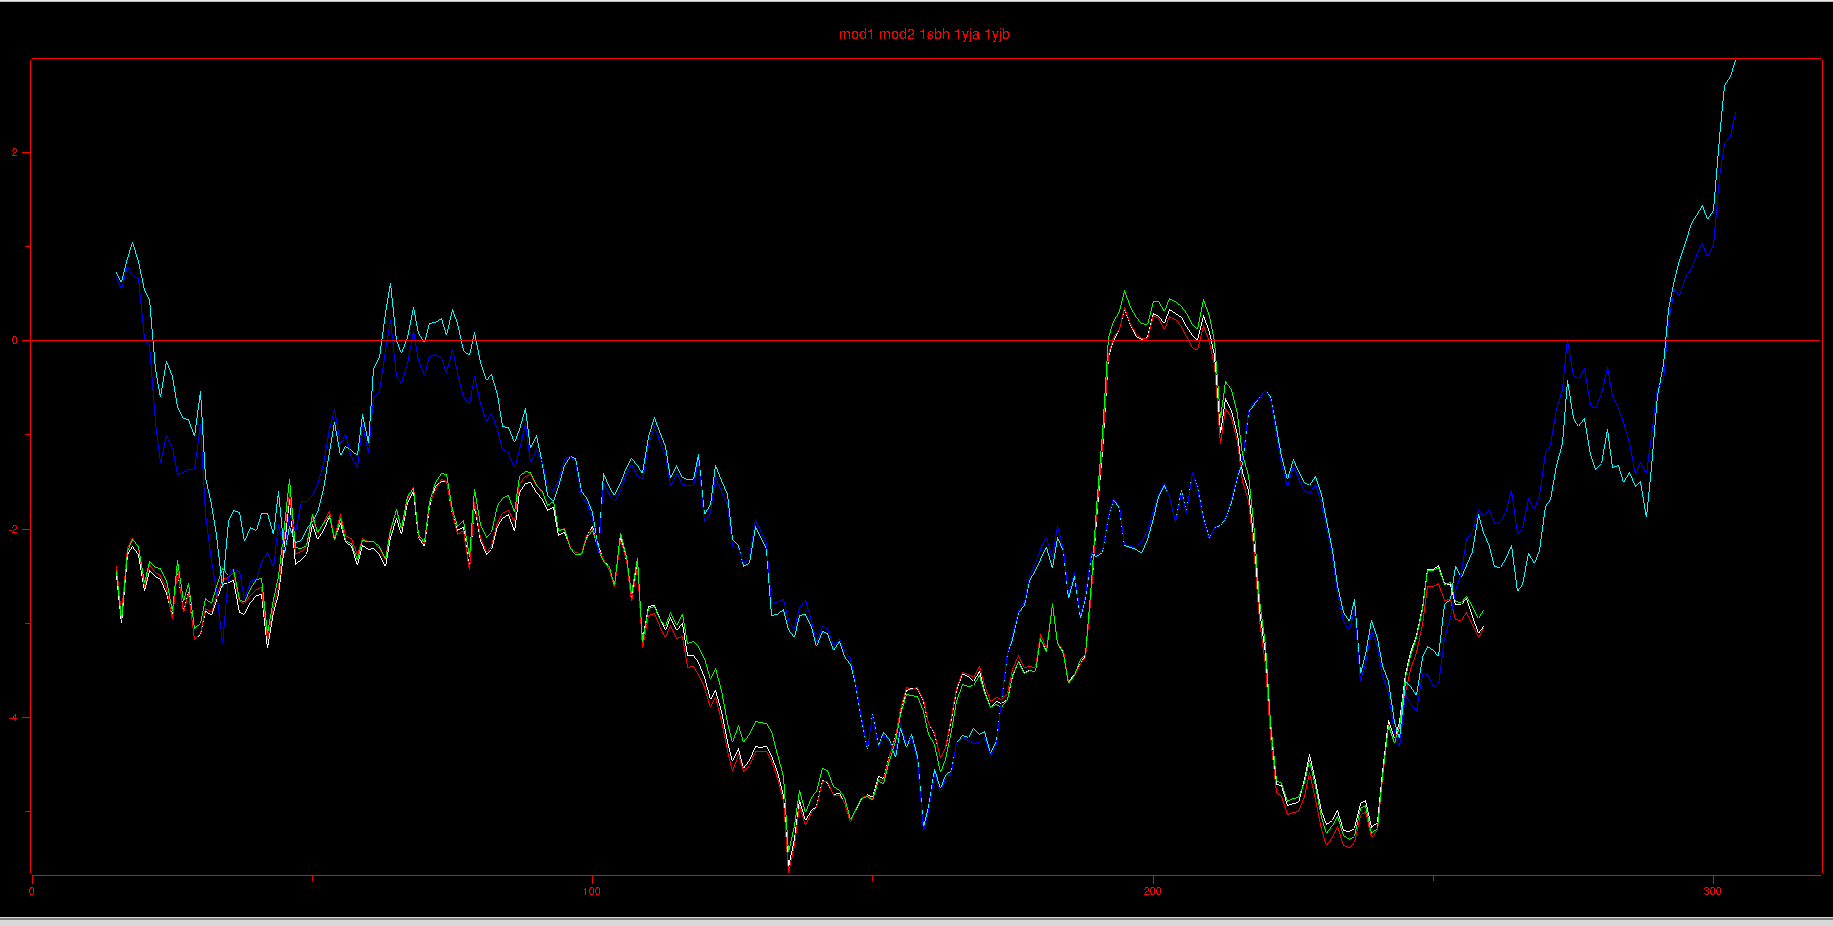

I see that on the region between 50-100 residus es passa dels 0. Ara hauré de fer una predicció de estructura secundaria amb dos programes (dssp i psipred) per veure lo que em diu la predicció (psipred) i lo que tinc (dssp), i veuré en quines regions hauria de forçar.

## 4.6. Prediction of the secondary structure to enhance the energy with dssp and psipred

El __DSSP__ t'extreurà l'estructura secundària real de les teves __plantilles (1sbhA, 1s01A, 1sbiA)__. 
- Veuràs exactament on acaben les hèlixs alfa i les làmines beta. 
- En les zones de "gap" de l'aliniament, el DSSP no et donarà informació per a la P11018 perquè, senzillament, la plantilla no té aquells residus.

El __PSIPRED__ mirarà només la seqüència de la __P11018__.

- Què busques? Mira si en aquesta regió (50-100) el PSIPRED prediu alguna hèlix o làmina que no apareix a les plantilles.

- Si el PSIPRED diu que hi ha una hèlix (H), però l'aliniament la posa en una zona de "loops", és aquí on hauràs de decidir si forces l'estructura.

```
PDBtoSplitChain.pl -i model1.pdb -o model1 
```
The previous steps is just to obtian ouyr model's fasta file. which will be used for the prediction step:

Secondary seq:

```dssp model1.pdb model1.dssp```

And for prediction of the secondary structure we do:

```
psipred model1.fa

# PSIPRED HFORMAT (PSIPRED V4.0)

Conf: 998054440136400237654898627874667885057998508999816999999406
Pred: CCCCEEEEECCCCCCCCCHHHCCCCCEEEECHHHHHCCCCCCCEEEEEEECCCCCCCHHH
  AA: MNGEIRLIPYVTNEQIMDVNELPEGIKVIKAPEMWAKGVKGKNIKVAVLDTGCDTSHPDL
              10        20        30        40        50        60


Conf: 114225657435999941022034688512534899617999634236540699999303
Pred: HCCEECCCCCCCCCCCCEECCCCCCCCCCEEEEEEEEECCCCCCCCCCCCEEEEEEEECC
  AA: KNQIIGGKNFTDDDGGKEDAISDYNGHGTHVAGTIAANDSNGGIAGVAPEASLLIVKVLG
              70        80        90       100       110       120


Conf: 678851016643333223740363898525994300899999999987695999836888
Pred: CCCCCCEEEEEECCCCHHHHCCCCEEEEECCCCCCHHHHHHHHHHHHHCCEEEEEECCCC
  AA: GENGSGQYEWIINGINYAVEQKVDIISMSLGGPSDVPELKEAVKNAVKNGVLVVCAAGNE
             130       140       150       160       170       180


Conf: 985401201356422063478736889998887505887132750686487639986544
Pred: CCCCCCCCCCCCCCCCCCEEEEECHHHHHHHHHHHCCCCEECEEECCCCHHHCCCCCCCC
  AA: GDGDERTEELSYPAAYNEVIAVGSVSVARELSEFSNANKEIDLVAPGENILSTLPNKKYG
             190       200       210       220       230       240


Conf: 435774212224479999984036768886467799999999425863898862586589
Pred: CCCCCCCCCCCHHHHHHHHHHHCHHHHHHHCCHHHHHHHHHHHHCCHHHHHHHCCCCEEE
  AA: KLTGTSMAAPHVSGALALIKSYEEESFQRKLSESEVFAQLIRRTLPLDIAKTLAGNGFLY
             250       260       270       280       290       300


Conf: 8472899999997013159
Pred: EECHHHHHHHHHHCCCCCC
  AA: LTAPDELAEKAEQSHLLTL
             310   

```
Aquest és un output de PSIPRED molt clar. Ara hem de creuar aquestes dades amb l'aliniament que hem vist abans, especialment en la "zona conflictiva" que havies detectat (residus 50-100). Anem a analitzar els punts clau on hauràs de prendre decisions per al teu model 3D:

### 4.5.1. La zona 50-100 (El "Loop" extra)

A l'aliniament, vèiem que les plantilles (`1sbhA`, etc.) tenien un gap enorme entre els residus 60 i 80 aproximadament. Mirant el PSIPRED:

* **Residus 63-71 (`KNQIIGGKN`):** El PSIPRED prediu majoritàriament **C** (Coil) i una petita hèlix terminal. Això és una bona notícia: confirma que aquesta inserció és un **bucle flexible** (loop). No preocupar-se per forçar hèlixs inexistents en aquesta regió; el modelador el construirà com un llaç.
* **Residus 85-95 (`THVAGTIAA`):** Aquí el PSIPRED prediu **E** (Strand/Llumina beta) amb una confiança alta (999...). Si et fixes en l'aliniament, aquesta zona correspon al "core" conservat. Si la plantilla té una làmina beta aquí, l'aliniament i la predicció coincideixen perfectament.

### 2. Zona de l'Histidina Catalítica (Residu 64 aprox.)

Com que és una subtilisina, la tríada catalítica és sagrada.

* A la regió del residu **64**, PSIPRED prediu un gir o coil. Això és correcte per permetre que l'histidina estigui exposada cap al centre actiu.

### 3. Possibles zones per "Forçar" (Restraints)

Hauràs de mirar el fitxer **DSSP** de les plantilles i comparar-lo amb això:

* **Regió 160-175 (`KEAVKNAVKNGVLVV`):** El PSIPRED prediu una **Hèlix Alfa molt llarga i forta** (confiança 9). Si en la teva plantilla (`1sbhA`) el DSSP diu que aquesta hèlix és més curta o que es trenca, aquí tens un candidat clar per **forçar l'estructura**.
* **Regió 200-215 (`VSVARELSEFSNAN`):** Una altra hèlix alfa molt clara (`HHHHHHHHHHH`). Si el teu aliniament té gaps o "punts" en aquesta zona, hauràs d'assegurar-te que el model mantingui l'hèlix contínua.

---

### Què has de fer ara per comparar amb DSSP?

El DSSP et donarà un fitxer amb lletres diferents (H per hèlix, E per làmina, etc.) per a cada residu de la plantilla. El que has de fer és:

1. **Alinear les files:** Posa la fila `Pred` de PSIPRED a sobre de la fila d'estructura secundària que t'ha donat el DSSP (usant l'aliniament múltiple com a guia).
2. **Detectar discrepàncies:** * Si PSIPRED diu **H** i DSSP diu **H**  Perfecte.
* Si PSIPRED diu **H** i DSSP diu **C** (o gap)  **Aquí és on hauràs de forçar.**


```model.ss2```ha sigut obtingut quan s'ha corregut ```psipred```, i és el matiex que el archiu horitzontal, però el script prefereix el format vertical (ss2). Volem l'aliniament en format pir tant de la predicció ```psipred.pir``` com de la estructura secundària ```ddsp.pir```:

````
psipred.pl model1.ss2 > psipred.pir

>P1;model1.ss2Seq 
model1.ss2Seq  
MNGEIRLIPYVTNEQIMDVNELPEGIKVIKAPEMWAKGVKGKNIKVAVLDTGCDTSHPDLKNQIIGGKNFTDDDGGKED
AISDYNGHGTHVAGTIAANDSNGGIAGVAPEASLLIVKVLGGENGSGQYEWIINGINYAVEQKVDIISMSLGGPSDVPEL
KEAVKNAVKNGVLVVCAAGNEGDGDERTEELSYPAAYNEVIAVGSVSVARELSEFSNANKEIDLVAPGENILSTLPNKKY
GKLTGTSMAAPHVSGALALIKSYEEESFQRKLSESEVFAQLIRRTLPLDIAKTLAGNGFLYLTAPDELAEKAEQSHLLTL
*
>P1;model1.ss2SS 
model1.ss2SS  
CCCCEEEEECCCCCCCCCHHHCCCCCEEEECHHHHHCCCCCCCEEEEEEECCCCCCCHHHHCCEECCCCCCCCCCCCEE
CCCCCCCCCCEEEEEEEEECCCCCCCCCCCCEEEEEEEECCCCCCCCEEEEEECCCCHHHHCCCCEEEEECCCCCCHHHH
HHHHHHHHHCCEEEEEECCCCCCCCCCCCCCCCCCCCCCEEEEECHHHHHHHHHHHCCCCEECEEECCCCHHHCCCCCCC
CCCCCCCCCCCCHHHHHHHHHHHCHHHHHHHCCHHHHHHHHHHHHCCHHHHHHHCCCCEEEEECHHHHHHHHHHCCCCCC
*



aliss_old.pl model1.dssp > dssp.pir


>P1;model1.dsspSeq
model1.dsspSeq 
MNGEIRLIPYVTNEQIMDVNELPEGIKVIKAPEMWAKGVKGKNIKVAVLDTGCDTSHPDLKNQIIGGKNFTDDDGGKEDA
ISDYNGHGTHVAGTIAANDSNGGIAGVAPEASLLIVKVLGGENGSGQYEWIINGINYAVEQKVDIISMSLGGPSDVPELK
EAVKNAVKNGVLVVCAAGNEGDGDERTEELSYPAAYNEVIAVGSVSVARELSEFSNANKEIDLVAPGENILSTLPNKKYG
KLTGTSMAAPHVSGALALIKSYEEESFQRKLSESEVFAQLIRRTLPLDIAKTLAGNGFLYLTAPDELAEKAEQSHLLTL*
>P1;model1.dsspSS
model1.dsspSS 
---------SS------------HHHHHTTHHHHHHHT-S-TT-EEEEEES---TT-TTSSSS-SEEEE--STT-TTT-T
T--SSSHHHHHHHHHH---SSSS---SSTTSEEEEEE-S-TTT----HHHHHHHHHHHHHTT-SEEEE---BS---HHHH
HHHHHHHHTT-EEEEE--S----SSS-----BTTTSTTSEEEEEE-TTS-B-TTS--STTEEEEEE-SSEEEEETTTEEE
EE-SHHHHHHHHHHHHHHHHHHS-SSSSS--SHHHHHHHHHHTSB--S-IIIIITT-B--SHHHH----S---------*
>P1;model1.dsspACC
model1.dsspACC 
WBCDDBEBGWCCDCDFWGEIEEAGAADIAGAGFAFDCGAHAFDAFAAAAAAAAIIDAEAAIFEAFHGFAAACCAIEBFFA
HGADGIIAAAAAAAAAAIFEFIAAAAAAAFAIAAAAAAAIABDHGHEHFHAAHAAGIAHDGDAIAAAAAIEACDGHCFAG
EAAFGAHCFGAAAAAAAIGEIEIWDDHGIAAIAAAABHAAAAAAAIEFFEHAWIAAAIDIAHAAAAAFGAGAAIICDFGH
DHFAAIAAAAAAAAAAAAAAIGAGCGFHGIGHHFAAHGIAHDGIGDHDFGEAHAAGAAAIAHHAAGDHCDDCFDCCDCW*

````

Ara ho tindrem en format .pir i una és el predicted i l'altra és la estructura secondaria. Ara les concatenem i transformem en format d'aliniament clustal:

````
cat psipred.pir > compare.pir
cat dssp.pir >> compare.pir
aconvertMod2.pl -in p -out c < compare.pi > compare.aln

CLUSTAL W(1.60) multiple sequence alignment

model1.ss2Seq   MNGEIRLIPYVTNEQIMDVNELPEGIKVIKAPEMWAKGVKGKNIKVAVLDTGCDTSHPDL
model1.ss2SS    CCCCEEEEECCCCCCCCCHHHCCCCCEEEECHHHHHCCCCCCCEEEEEEECCCCCCCHHH
model1.dsspSeq  MNGEIRLIPYVTNEQIMDVNELPEGIKVIKAPEMWAKGVKGKNIKVAVLDTGCDTSHPDL
model1.dsspSS   ---------SS------------HHHHHTTHHHHHHHT-S-TT-EEEEEES---TT-TTS
model1.dsspACC  WBCDDBEBGWCCDCDFWGEIEEAGAADIAGAGFAFDCGAHAFDAFAAAAAAAAIIDAEAA

model1.ss2Seq   KNQIIGGKNFTDDDGGKEDAISDYNGHGTHVAGTIAANDSNGGIAGVAPEASLLIVKVLG
model1.ss2SS    HCCEECCCCCCCCCCCCEECCCCCCCCCCEEEEEEEEECCCCCCCCCCCCEEEEEEEECC
model1.dsspSeq  KNQIIGGKNFTDDDGGKEDAISDYNGHGTHVAGTIAANDSNGGIAGVAPEASLLIVKVLG
model1.dsspSS   SSS-SEEEE--STT-TTT-TT--SSSHHHHHHHHHH---SSSS---SSTTSEEEEEE-S-
model1.dsspACC  IFEAFHGFAAACCAIEBFFAHGADGIIAAAAAAAAAAIFEFIAAAAAAAFAIAAAAAAAI

model1.ss2Seq   GENGSGQYEWIINGINYAVEQKVDIISMSLGGPSDVPELKEAVKNAVKNGVLVVCAAGNE
model1.ss2SS    CCCCCCEEEEEECCCCHHHHCCCCEEEEECCCCCCHHHHHHHHHHHHHCCEEEEEECCCC
model1.dsspSeq  GENGSGQYEWIINGINYAVEQKVDIISMSLGGPSDVPELKEAVKNAVKNGVLVVCAAGNE
model1.dsspSS   TTT----HHHHHHHHHHHHHTT-SEEEE---BS---HHHHHHHHHHHHTT-EEEEE--S-
model1.dsspACC  ABDHGHEHFHAAHAAGIAHDGDAIAAAAAIEACDGHCFAGEAAFGAHCFGAAAAAAAIGE

model1.ss2Seq   GDGDERTEELSYPAAYNEVIAVGSVSVARELSEFSNANKEIDLVAPGENILSTLPNKKYG
model1.ss2SS    CCCCCCCCCCCCCCCCCCEEEEECHHHHHHHHHHHCCCCEECEEECCCCHHHCCCCCCCC
model1.dsspSeq  GDGDERTEELSYPAAYNEVIAVGSVSVARELSEFSNANKEIDLVAPGENILSTLPNKKYG
model1.dsspSS   ---SSS-----BTTTSTTSEEEEEE-TTS-B-TTS--STTEEEEEE-SSEEEEETTTEEE
model1.dsspACC  IEIWDDHGIAAIAAAABHAAAAAAAIEFFEHAWIAAAIDIAHAAAAAFGAGAAIICDFGH

model1.ss2Seq   KLTGTSMAAPHVSGALALIKSYEEESFQRKLSESEVFAQLIRRTLPLDIAKTLAGNGFLY
model1.ss2SS    CCCCCCCCCCCHHHHHHHHHHHCHHHHHHHCCHHHHHHHHHHHHCCHHHHHHHCCCCEEE
model1.dsspSeq  KLTGTSMAAPHVSGALALIKSYEEESFQRKLSESEVFAQLIRRTLPLDIAKTLAGNGFLY
model1.dsspSS   EE-SHHHHHHHHHHHHHHHHHHS-SSSSS--SHHHHHHHHHHTSB--S-IIIIITT-B--
model1.dsspACC  DHFAAIAAAAAAAAAAAAAAIGAGCGFHGIGHHFAAHGIAHDGIGDHDFGEAHAAGAAAI

model1.ss2Seq   LTAPDELAEKAEQSHLLTL
model1.ss2SS    EECHHHHHHHHHHCCCCCC
model1.dsspSeq  LTAPDELAEKAEQSHLLTL
model1.dsspSS   SHHHH----S---------
model1.dsspACC  AHHAAGDHCDDCFDCCDCW
````

La seqüència predita amb la original, __han de tenir la mateixa seq!!!__, si no, no és poden comparar!.






El gràfic de ProSA (segona imatge) és clau: ens indica l'energia local del model. Quan el valor puja per sobre de 0 (la línia vermella), significa que el model en aquella regió té una energia massa alta, és a dir, és estructuralment inestable o té un plegament incorrecte.


Basant-nos en el gràfic de prosa, les zones a arreglar serien:

- 1. Zona 0 - 40 (L'inici del model)

Al gràfic ProSA, veiem que l'energia puja per sobre de 0 just al principi.

L'aliniament: Si mires el fitxer compare.aln, el DSSP de la plantilla té molts guions (----) o falta d'estructura en els primers residus.

PSIPRED: Prediu una hèlix (HHH) al voltant del residu 19 i una làmina beta (EEEEE) al principi.

Diagnòstic: El modelador està "patint" aquí perquè no té una plantilla clara per a l'extrem N-terminal. L'energia alta de ProSA confirma que aquest tros està "flotant" malament.

- 2. Zona 50 - 100 (El gran conflicte)

Aquesta és la zona on el ProSA dóna els valors més positius (especialment prop del residu 60-80).

El motiu: Aquí és on tenies la inserció més gran (KNQIIGGKN...).

L'aliniament: Fixa't que a compare.aln el PSIPRED prediu una estructura de fulla beta (EE) que no existeix en absolut al DSSP de la plantilla.

Solució: Aquesta regió té una energia dolenta perquè el modelador ha intentat fer un bucle (loop) sense cap guia. Hauràs de revisar si pots trobar una plantilla alternativa només per a aquest tros o deixar que el programa faci una cerca de bucles més exhaustiva.

- La zona final (300-final)

PSIPRED: Prediu una hèlix terminal molt clara (HHHHHHHHHH).

DSSP: Diu que l'hèlix es trenca molt ràpid (SHHHH----S).

Acció: Aquesta és una zona clàssica per forçar. Les proteïnes sovint tenen cues terminals flexibles que en el cristall (DSSP) semblen desordenades, però que en realitat formen hèlixs. Jo forçaria aquesta hèlix final perquè el model quedi més estable.

Aplicar aquestes restriccions secundàries per intentar "baixar" l'energia del ProSA